# Scatter plot with Gaussian KDE

In [1]:
import os
import glob
from pathlib import Path 
import sys
import fnmatch
from itertools import cycle
from functools import partial
from math import log10, sqrt, ceil, floor, log, exp, pi, isnan
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=30)
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmapy
import pandas as pd
import cv2
from scipy import fftpack
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.signal import convolve2d
import seaborn as sns
from tqdm.notebook import tqdm, trange
from skimage import color
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler
import skimage.filters as skf
from skimage.filters import laplace, threshold_otsu
import skimage.exposure as ske
from skimage.transform import rescale
from skimage.util import view_as_windows
from skimage.metrics import mean_squared_error as mse
from statannot import add_stat_annotation
import scipy
import pickle
import time
from scipy.stats import kde, gaussian_kde
 

import multiprocessing as mp
from multiprocessing import Process, Queue, Value, Array, Pool

import matplotlib.font_manager as fm
%matplotlib inline
%gui qt5

C:\Users\nzhang326\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
os.chdir('..')
os.chdir('./src')

In [4]:
from my_io import display_list_image, read_tiff_files
from config import *

In [5]:
# Figures location    
save_path = f"{data_figure}/scatterplot/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Scatterplot colored using Gaussian kde

In [6]:
def scatter_with_gaussian_kde(df, marker1, marker2, celltype, filepath):
    df_sample = df.sample(50000, random_state=1)
    # create data
    x = df_sample[marker1]/255
    y = df_sample[marker2]/255

    # calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x, y, c=z, s=10)
    matplotlib.rcParams.update({'font.size': 25})
    plt.xlabel(marker1, fontsize = 25)
    plt.ylabel(marker2, fontsize = 25)
    plt.xlim(0,1)
    plt.ylim(0,1)
    image_path_png = filepath + "/" + "scatter_" + marker1 + "_" + marker2 + "_" + celltype + ".png"
    plt.savefig(image_path_png, edgecolor='none', bbox_inches="tight")
    plt.show()

### Load the datasets

In [7]:
pickle_name_temp = f"{data_path_masked_BM}/image_list_BM.pickle"
zoomed_image_list_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/image_list_UC.pickle"
zoomed_image_list_UC = pickle.load(open(pickle_name_temp, "rb"))

In [8]:
pickle_name_temp = f"{data_path_masked_BM}/mask_list_BM.pickle"
zoomed_mask_list_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/mask_list_UC.pickle"
zoomed_mask_list_UC = pickle.load(open(pickle_name_temp, "rb"))

### Mitochondria markers

In [9]:
BM_indices_mito = [2, 3, 5, 8, 13, 14, 17, 18, 28, 29, 30]
UC_indices_mito = [0, 1, 2, 3, 6, 7, 8, 9, 11, 17, 26, 30, 31, 33]

In [10]:
df_BM_mito = pd.DataFrame()

for x in trange(len(BM_indices_mito)):
    m = BM_indices_mito[x]
    pd_images = pd.DataFrame()
    images_temp = zoomed_image_list_BM[m].copy()
    masks_temp = zoomed_mask_list_BM[m].copy()/255
    
    array_i_index = np.zeros(images_temp[0].shape)
    array_j_index = np.zeros(images_temp[0].shape)
    for i in range(array_i_index.shape[0]):
        for j in range(array_i_index.shape[1]):
            array_i_index[i, j] = i
            array_j_index[i, j] = j
            
    pd_images_temp = pd.DataFrame(images_temp.reshape(11, -1).T, columns=channel_names)
    
    pd_images_temp['cell'] = x
    pd_images_temp['mask'] = masks_temp.reshape(-1).copy()
    pd_images_temp['index_i'] = array_i_index.reshape(-1)
    pd_images_temp['index_j'] = array_j_index.reshape(-1)
    
    pd_images_temp = pd_images_temp[pd_images_temp['mask'] == 1.0]
    pd_images_temp = pd_images_temp[(pd_images_temp['HSP60'] > 0.0) | (pd_images_temp['TOM20'] > 0.0)]
    pd_images_temp = pd_images_temp[['cell', 'HSP60', 'TOM20']]
        
    df_BM_mito = pd.concat([df_BM_mito, pd_images_temp], axis=0)

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
df_UC_mito = pd.DataFrame()

for x in trange(len(UC_indices_mito)):
    m = UC_indices_mito[x]
    pd_images = pd.DataFrame()
    images_temp = zoomed_image_list_UC[m].copy()
    masks_temp = zoomed_mask_list_UC[m].copy()/255
    
    array_i_index = np.zeros(images_temp[0].shape)
    array_j_index = np.zeros(images_temp[0].shape)
    for i in range(array_i_index.shape[0]):
        for j in range(array_i_index.shape[1]):
            array_i_index[i, j] = i
            array_j_index[i, j] = j
            
    pd_images_temp = pd.DataFrame(images_temp.reshape(11, -1).T, columns=channel_names)
    
    pd_images_temp['cell'] = x
    pd_images_temp['mask'] = masks_temp.reshape(-1).copy()
    pd_images_temp['index_i'] = array_i_index.reshape(-1)
    pd_images_temp['index_j'] = array_j_index.reshape(-1)
    
    pd_images_temp = pd_images_temp[pd_images_temp['mask'] == 1.0]
    pd_images_temp = pd_images_temp[(pd_images_temp['HSP60'] > 0.0) | (pd_images_temp['TOM20'] > 0.0)]
    pd_images_temp = pd_images_temp[['cell', 'HSP60', 'TOM20']]
        
    df_UC_mito = pd.concat([df_UC_mito, pd_images_temp], axis=0)

  0%|          | 0/14 [00:00<?, ?it/s]

In [12]:
df_BM_mito

,cell,HSP60,TOM20
1016,0,0.560966,0.000000
1017,0,0.085074,0.000000
1018,0,0.187051,0.000000
1522,0,0.628950,0.000000
1523,0,0.289027,0.000000
...,...,...,...
740206,10,9.897884,10.557888
741152,10,7.360955,6.368386
741153,10,7.665387,10.719023
741154,10,7.868341,5.562712


In [13]:
df_UC_mito

,cell,HSP60,TOM20
1677,0,0.241399,2.823490
1678,0,0.000000,4.661432
1679,0,0.048280,4.967756
1680,0,0.579359,4.967756
1681,0,0.000000,5.580403
...,...,...,...
859637,13,16.837629,1.138639
859638,13,15.548514,0.435593
859639,13,12.922539,0.435593
859640,13,11.919893,0.499507


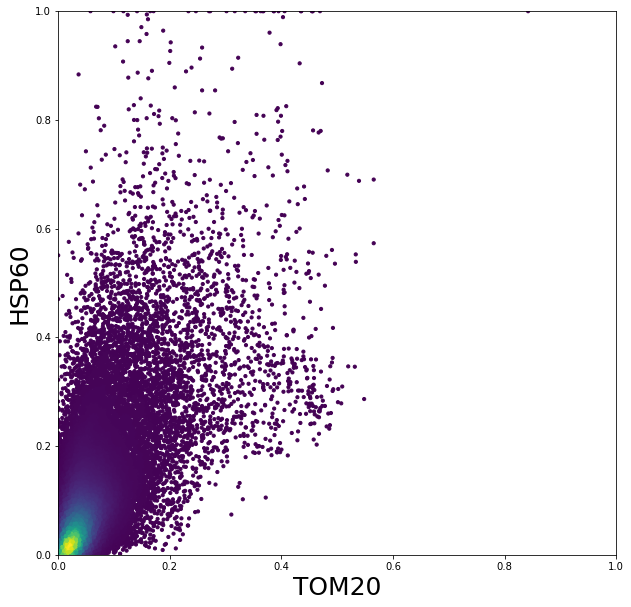

In [14]:
scatter_with_gaussian_kde(df_BM_mito, "TOM20", "HSP60", "BM", save_path)

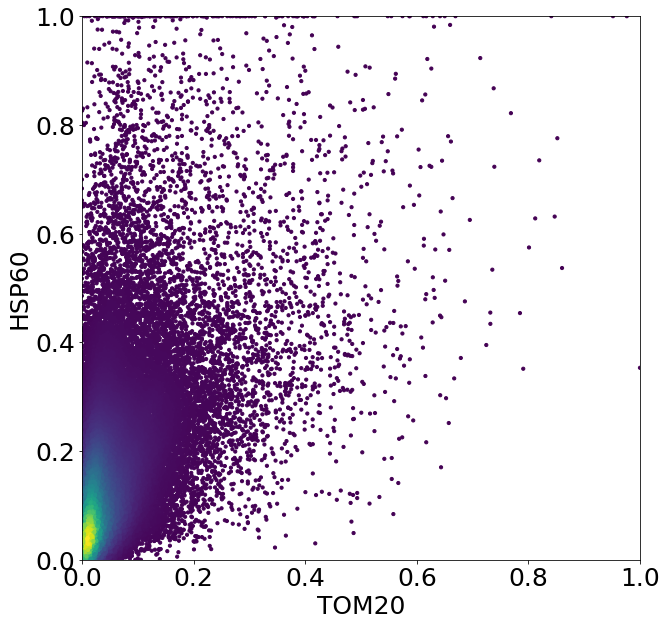

In [15]:
scatter_with_gaussian_kde(df_UC_mito, "TOM20", "HSP60", "UC", save_path)

### Golgi markers

In [16]:
BM_indices_golgi = [2, 3, 5, 7, 8, 13, 14, 18, 25, 28, 29, 30]
UC_indices_golgi = [0, 6, 7, 8, 9, 10, 11, 17, 19, 23, 30, 31, 33]

In [17]:
df_BM_golgi = pd.DataFrame()

for x in trange(len(BM_indices_golgi)):
    m = BM_indices_golgi[x]
    pd_images = pd.DataFrame()
    images_temp = zoomed_image_list_BM[m].copy()
    masks_temp = zoomed_mask_list_BM[m].copy()/255
    
    array_i_index = np.zeros(images_temp[0].shape)
    array_j_index = np.zeros(images_temp[0].shape)
    for i in range(array_i_index.shape[0]):
        for j in range(array_i_index.shape[1]):
            array_i_index[i, j] = i
            array_j_index[i, j] = j
            
    pd_images_temp = pd.DataFrame(images_temp.reshape(11, -1).T, columns=channel_names)
    
    pd_images_temp['cell'] = x
    pd_images_temp['mask'] = masks_temp.reshape(-1).copy()
    pd_images_temp['index_i'] = array_i_index.reshape(-1)
    pd_images_temp['index_j'] = array_j_index.reshape(-1)
    
    pd_images_temp = pd_images_temp[pd_images_temp['mask'] == 1.0]
    pd_images_temp = pd_images_temp[['cell', 'GOLPH4', 'Sortilin']]
        
    df_BM_golgi = pd.concat([df_BM_golgi, pd_images_temp], axis=0)

  0%|          | 0/12 [00:00<?, ?it/s]

In [18]:
df_UC_golgi = pd.DataFrame()

for x in trange(len(UC_indices_golgi)):
    m = UC_indices_golgi[x]
    pd_images = pd.DataFrame()
    images_temp = zoomed_image_list_UC[m].copy()
    masks_temp = zoomed_mask_list_UC[m].copy()/255
    
    array_i_index = np.zeros(images_temp[0].shape)
    array_j_index = np.zeros(images_temp[0].shape)
    for i in range(array_i_index.shape[0]):
        for j in range(array_i_index.shape[1]):
            array_i_index[i, j] = i
            array_j_index[i, j] = j
            
    pd_images_temp = pd.DataFrame(images_temp.reshape(11, -1).T, columns=channel_names)
    
    pd_images_temp['cell'] = x
    pd_images_temp['mask'] = masks_temp.reshape(-1).copy()
    pd_images_temp['index_i'] = array_i_index.reshape(-1)
    pd_images_temp['index_j'] = array_j_index.reshape(-1)
    
    pd_images_temp = pd_images_temp[pd_images_temp['mask'] == 1.0]
    pd_images_temp = pd_images_temp[['cell', 'GOLPH4', 'Sortilin']]
        
    df_UC_golgi = pd.concat([df_UC_golgi, pd_images_temp], axis=0)

  0%|          | 0/13 [00:00<?, ?it/s]

In [19]:
df_BM_golgi

,cell,GOLPH4,Sortilin
5,0,0.000000,0.000000
511,0,0.000000,0.000000
512,0,0.000000,0.000000
1016,0,0.000000,0.000000
1017,0,0.000000,0.000000
...,...,...,...
740206,11,4.515351,23.321694
741152,11,3.284354,31.703089
741153,11,0.959137,34.690517
741154,11,3.147576,32.200994


In [20]:
df_UC_golgi

,cell,GOLPH4,Sortilin
1677,0,3.948687,0.000000
1678,0,4.152983,2.196319
1679,0,2.518614,4.353128
1680,0,1.292837,3.873837
1681,0,1.497133,7.947810
...,...,...,...
859637,12,1.459213,4.507565
859638,12,2.094717,3.067615
859639,12,1.141462,4.687559
859640,12,0.585396,2.707628


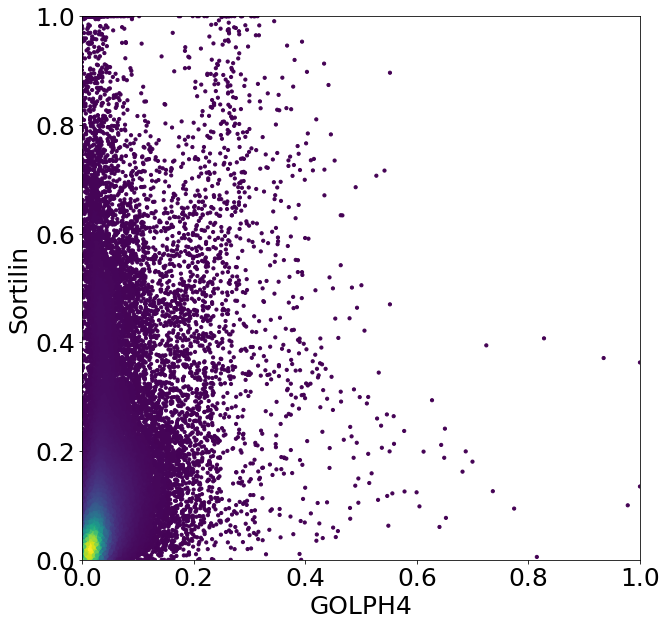

In [21]:
scatter_with_gaussian_kde(df_BM_golgi, "GOLPH4", "Sortilin", "BM", save_path)

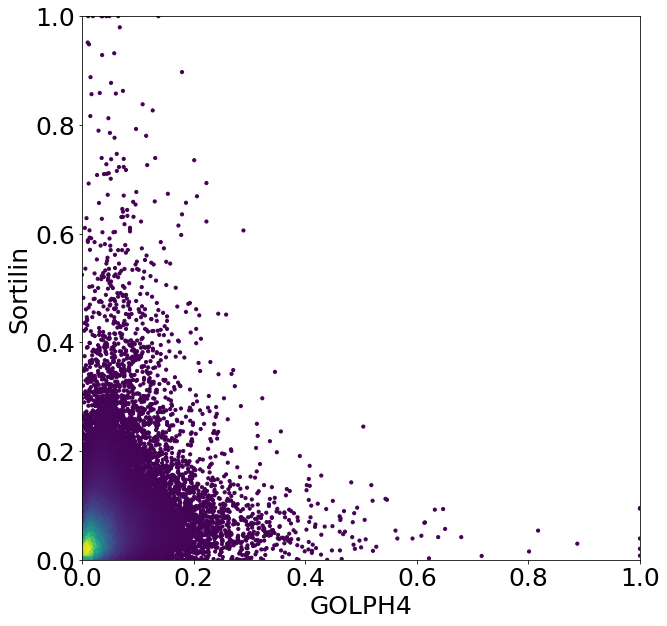

In [22]:
scatter_with_gaussian_kde(df_UC_golgi, "GOLPH4", "Sortilin", "UC", save_path)

### ER Markers

In [23]:
BM_indices_er = [3, 8, 14, 18]
UC_indices_er = [0, 6, 8, 9, 10, 11, 31, 33]

In [24]:
df_BM_er = pd.DataFrame()

for x in trange(len(BM_indices_er)):
    m = BM_indices_er[x]
    pd_images = pd.DataFrame()
    images_temp = zoomed_image_list_BM[m].copy()
    masks_temp = zoomed_mask_list_BM[m].copy()/255
    
    array_i_index = np.zeros(images_temp[0].shape)
    array_j_index = np.zeros(images_temp[0].shape)
    for i in range(array_i_index.shape[0]):
        for j in range(array_i_index.shape[1]):
            array_i_index[i, j] = i
            array_j_index[i, j] = j
            
    pd_images_temp = pd.DataFrame(images_temp.reshape(11, -1).T, columns=channel_names)
    
    pd_images_temp['cell'] = x
    pd_images_temp['mask'] = masks_temp.reshape(-1).copy()
    pd_images_temp['index_i'] = array_i_index.reshape(-1)
    pd_images_temp['index_j'] = array_j_index.reshape(-1)
    
    pd_images_temp = pd_images_temp[pd_images_temp['mask'] == 1.0]
    pd_images_temp = pd_images_temp[['cell', 'ATF6', 'ConcanavalinA']]
        
    df_BM_er = pd.concat([df_BM_er, pd_images_temp], axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
df_UC_er = pd.DataFrame()

for x in trange(len(UC_indices_er)):
    m = UC_indices_er[x]
    pd_images = pd.DataFrame()
    images_temp = zoomed_image_list_UC[m].copy()
    masks_temp = zoomed_mask_list_UC[m].copy()/255
    
    array_i_index = np.zeros(images_temp[0].shape)
    array_j_index = np.zeros(images_temp[0].shape)
    for i in range(array_i_index.shape[0]):
        for j in range(array_i_index.shape[1]):
            array_i_index[i, j] = i
            array_j_index[i, j] = j
            
    pd_images_temp = pd.DataFrame(images_temp.reshape(11, -1).T, columns=channel_names)
    
    pd_images_temp['cell'] = x
    pd_images_temp['mask'] = masks_temp.reshape(-1).copy()
    pd_images_temp['index_i'] = array_i_index.reshape(-1)
    pd_images_temp['index_j'] = array_j_index.reshape(-1)
    
    pd_images_temp = pd_images_temp[pd_images_temp['mask'] == 1.0]
    pd_images_temp = pd_images_temp[['cell', 'ATF6', 'ConcanavalinA']]
        
    df_UC_er = pd.concat([df_UC_er, pd_images_temp], axis=0)

  0%|          | 0/8 [00:00<?, ?it/s]

In [26]:
df_BM_er

,cell,ATF6,ConcanavalinA
531,0,2.360175,6.735946
532,0,1.070878,0.835454
533,0,6.514575,2.310577
534,0,1.357389,6.145897
1638,0,3.649471,17.356833
...,...,...,...
348694,3,0.000000,20.609819
348695,3,0.000000,22.246901
348696,3,0.979570,32.396814
349711,3,2.315004,11.769572


In [27]:
df_UC_er

,cell,ATF6,ConcanavalinA
1677,0,4.641346,3.101509
1678,0,10.054738,4.605119
1679,0,9.668067,8.364142
1680,0,5.414687,7.612337
1681,0,24.361560,7.361736
...,...,...,...
859637,7,1.192160,21.526330
859638,7,3.034732,28.616508
859639,7,5.696225,0.053221
859640,7,0.885064,10.789776


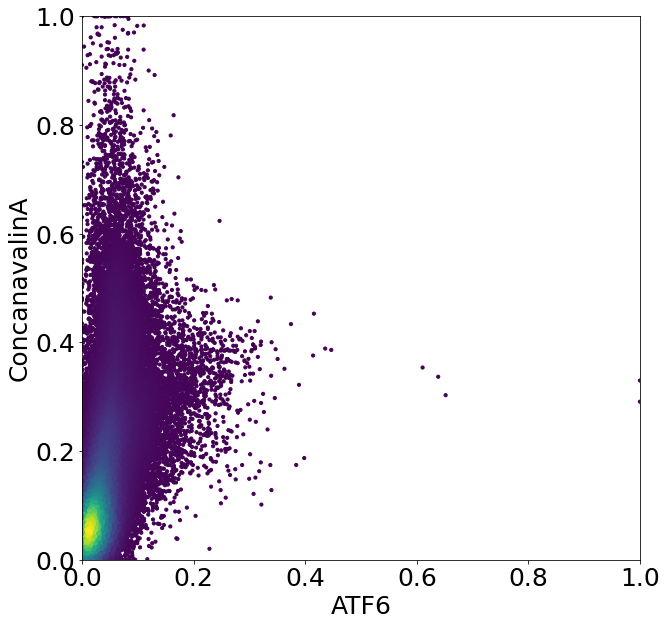

In [28]:
scatter_with_gaussian_kde(df_BM_er, "ATF6", "ConcanavalinA", "BM", save_path)

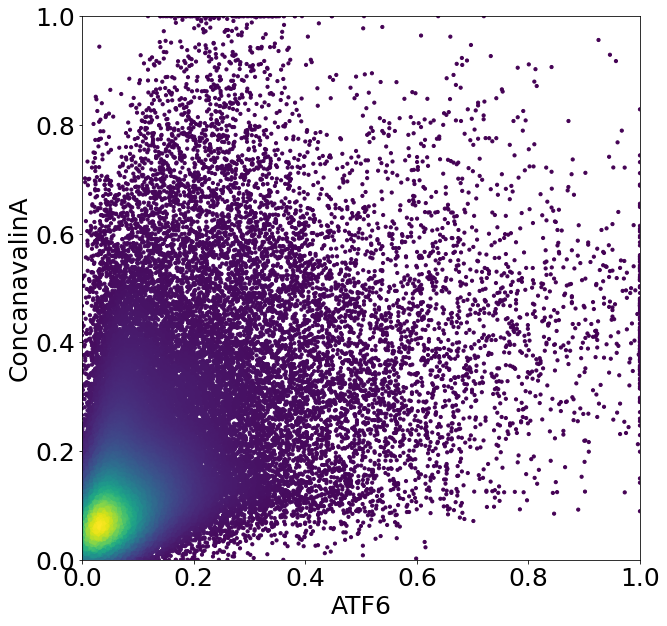

In [29]:
scatter_with_gaussian_kde(df_UC_er, "ATF6", "ConcanavalinA", "UC", save_path)